# M/EEG analysis with MNE Python
<i>IMPRS - Using Python for Cognitive Science (2020)</i>

Good morning! Today we will be working through this tutorial to get familiar with MNE. We are going to do an analysis of MEG/EEG data provided by MNE. The content of today is as follows:

0. Importing modules
1. Loading data (the <b>Raw</b> data structure)
2. Preprocessing
3. Detecting experimental events
4. Epoching (the <b>Epochs</b> data structure)
5. Evoked responses (the <b>Evoked</b> data structure)

## 0. Importing modules
We will need <b>os</b>, <b>NumPy</b>, <b>matplotlib</b>, and (of course) <b>MNE-Python</b> ("import mne").

Import them below.

In [1]:
# Your code here
import os
import numpy as np
import matplotlib
import mne

## 1. Loading data: the <i>Raw</i> data structure

MNE-Python uses the FIF file format from Neuromag. The MPI EEG uses xxxx and the Donders MEG are xxxx - that is not a problem, because MNE provides data reader-functions for a wide variety of other data formats.

We are going to download the example dataset. Notice that we are downloading the data using ```mne.datasets.sample.data_path()```. This may take a while.

In [2]:
default_path = mne.datasets.sample.data_path()
raw_fname = os.path.join(default_path, 'MEG', 'sample', 'sample_audvis_raw.fif')

To access the data, we use ```read_raw_fif``` function. This creates an instance of MNE's Raw class (= an object!). The Raw object has an attribute <i>info</i>: this attribute contains information about the dataset.

Here, we will load the data into memory ```preload``` flag inside the reader function. If we don't do that, the data will be retrieved on the go instead of loading it to memory. This is useful if you're working with multiple participants' data: the memory of your computer is not unlimited.

Good to know is that you can still access the info attribute if you don't preload the data.

In [3]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file C:\Users\sopsla\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


Print the raw object below to see what information it gives you. Then print the info attribute. What new information do you see? What is the sampling frequency of the data, how many bad channels are there?

In [4]:
# your code here
print(raw)
print(raw.info)

<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.8 MB, data loaded>
<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 GRAD, 102 MAG, 9 STIM, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>


To access a particular element of this dictionary, you can use square brackets as you would with a normal Python dictionary. Try printing the sampling rate, bad channels, and channel names below.

In [ ]:
# Complete the code by replacing the underscores _______
print('Sampling rate: ', int(_______), 'Hz')
print('Bad channels: ', _______)

# For channel names, it is not mandatory to access through info
# Try printing the channels as an attribute of the raw object
print('Channel names: ', _______)

In [ ]:
# Complete the code by replacing the underscores _______
print('Sampling rate: ', int(raw.info['sfreq']), 'Hz')
print('Bad channels: ', raw.info['bads'])
# For channel names, it is not mandatory to access through info
# Try printing the channels as an attribute of the raw object
print('Channel names: ', raw.ch_names)

The Raw object also has a couple of built-in plotting methods, such as the power spectral density using ```plot_psd``` and the raw sensor traces using ```plot``` (some parameters: duration (seconds) and n_channels). 

In [ ]:
# power spectral density
psd_plot = raw.plot_psd(fmax=100)

Try to plot 2 seconds of data for 30 channels below.

In [ ]:
# your code here
ch_plot = raw.plot(duration=2, n_channels=30)

The raw object also has some other useful methods to manipulate the data. Some of them are:

* ```raw.copy()``` - Get a deep copy of the raw data to avoid modifying the original files
* ```raw.crop([tmin, tmax])``` - Crop the data based on time
* ```raw.get_data([picks, start, stop,...])``` - Get specific parts of the data, without metadata
* ```raw.filter(l_freq, h_freq[,picks,...])``` - Apply band-pass filters
* ```raw.resample(sfreq[,npad, window, stim_picks, ...])``` - Change the sampling rate of the data
* ```raw.save(fname[,picks, tmin, tmax,...])``` - Save data (possibly after preprocessing)
* ```raw.set_eeg_reference()``` - Specify the reference for EEG data
* ```raw.to_data_frame()``` - Export data as a DataFrame to use with MATLAB/R/Pandas

## 2. Preprocessing

### 2.1 Filtering data
After examining your data, the first thing you do is filter them based on what kind of analysis you want to do. For an ERP and time-frequency analysis, you would normally want to get rid of very high (e.g., above 100Hz) and very low (e.g., below 0.1 Hz) frequencies. It is important to also remove power line noise (e.g., 50Hz or 60Hz and their harmonics).

The values for your low and high pass filters depend on your effect of interest, but cannot exceed the nyquist frequency defined by your sampling rate. That is, it cannot be higher than your sampling rate divided by 2.

What is our sampling rate? What is the maximum frequency to include in our data?

To filter data with MNE, you first need to select which data are going to be filtered, and subsequently apply the respective filters only on that part of the data (i.e., we don't want to filter the stimulus channel). To accomplish this, we use the MNE function ```pick_types()```. 

The function has the following signature:

```mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=False, ecg=False, emg=False, ref_meg='auto', misc=False, resp=False, chpi=False, exci=False, ias=False, syst=False, seeg=False, dipole=False, gof=False, bio=False, ecog=False, fnirs=False, include=(), exclude='bads', selection=None)```

In the code cell below, try to use mne.pick_types() to select the MEG channels. Assign them to a variable "picks", and print the result. Note: you don't have to specify all of them. 'False' is the default for most channel types, so they will be excluded if you don't specify them.

In [5]:
# Your code here
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=False, stim=False,
                       exclude='bads')

# It returns the IDs of the channels that correspond to this description
print(picks)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

There are three ways of applying filters to the data. You can either use a method from MNE on the data using `mne.filter.filter_data(data, sfreq, picks, l_freq, h_freq)` or directly apply the filter to the raw data using `raw.filter(picks, l_freq, h_freq)` for low/high pass filters, and `raw.notch_filter(freqs, picks)` to remove power line noise.


---


1. ```mne.filter.filter_data(data, sfreq, l_freq, h_freq, picks=None, filter_length='auto', l_trans_bandwidth='auto', h_trans_bandwidth='auto', n_jobs=1, method='fir', iir_params=None, copy=True, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', verbose=None)```




2. ```raw.filter(l_freq, h_freq, picks=None, filter_length='auto', l_trans_bandwidth='auto', h_trans_bandwidth='auto', n_jobs=1, method='fir', iir_params=None, phase='zero', fir_window='hamming', fir_design='firwin', skip_by_annotation=('edge', 'bad_acq_skip'), pad='reflect_limited', verbose=None)```




3. ```raw.notch_filter(freqs, picks=None, filter_length='auto', notch_widths=None, trans_bandwidth=1.0, n_jobs=1, method='fir', iir_params=None, mt_bandwidth=None, p_value=0.05, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', verbose=None)```


---


The difference is that mne.filter.filter_data() will apply the filters and return a copy, while the other two methods will apply the filters in-place (directly on the data).

By default, MNE applies a FIR filter with Hanning window, but this can be modified to design specific filters. A detailed discussion of filter design is beyond the scope of this tutorial. For more in-depth information on filtering, you can visit [this website](https://mne.tools/stable/generated/mne.filter.create_filter.html#mne.filter.create_filter).

Apply a bandpass filter from 1 to 100 Hz and a notch filter at 60Hz and its first harmonic (120Hz) on our selected channels ("picks"). Note: the frequencies in ```raw.notch_filter``` are specified by a list of integers (in our case ```[60, 120]```).

Then use the ```plot_psd()``` method to visualise what you've done.

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1983 samples (3.302 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidt

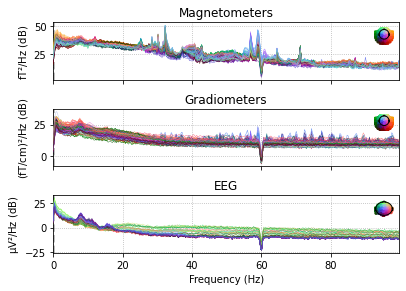

In [6]:
# Your code here
raw.filter(picks = picks, l_freq = 1, h_freq = 100)
raw.notch_filter([60, 120])
psd_plot_filt = raw.plot_psd(fmax=100)

If you want to try different values for the filters, you have to reload the data: you have modified the data loaded in the variable ```raw```, but not the data saved on disk. If you want, you can try it in the block below. Make sure to use a different variable name (not "raw").

In [ ]:
# Your code here

If you wanted to save your data at this point, you could do this by using:
    ```[your_varname].save('[YOUR_FILENAME].fif')```

## 3. Artifact removal
MNE-Python supports a lot of processing approaches and techniques for artifact correction. Here we'll use Independent Component Analysis (ICA). ICA separates the data into a given number of underlying components. ICA can capture systematic variability caused by physiological processes, such as blinking, breathing, and the heartbeat, in a small number of components. These components have to be identified and removed to clean the data.

In [9]:
from mne.preprocessing import ICA

There are different methods for ICA. We will use MNE's default: FastICA. 

To performICA, you have to create an instance of the ICA class, fit it to the data, and then plot the components. To create an ICA instance, use:

```ICA(n_components=None, max_pca_components=None, n_pca_components=None, noise_cov=None, random_state=None, method='fastica', fit_params=None, max_iter=200, verbose=None)```

Where ```n_components``` can be a number of components or a percentage of the data explained, e.g. ```25``` for 25 components, or ```0.95``` for 95% of the data explained.

In [10]:
method = 'fastica'
n_components = 25
random_state = 23  # this number guarantees that anyone running the script will get the same results

ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA | no decomposition, fit (fastica):  samples, no dimension reduction>


OK, now we have an instance of the ICA class that we can apply to the data. 
First, for faster processing, resample the data to 200Hz below using ```raw.resample(sfreq)```.
Then apply the ICA to the data using ```ica.fit(data, picks)```.

In [7]:
# Your code here
raw.resample(sfreq=200)

320 events found
Event IDs: [ 1  2  3  4  5 32]
320 events found
Event IDs: [ 1  2  3  4  5 32]


<Raw | sample_audvis_raw.fif, 376 x 55543 (277.7 s), ~162.6 MB, data loaded>

In [11]:
# Your code here
ica.fit(raw, picks)

Fitting ICA to data using 305 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 25 components
Fitting ICA took 21.4s.


<ICA | raw data decomposition, fit (fastica): 55543 samples, 25 components, channels used: "mag"; "grad">

You can visualize the topographic maps of the components by using the ```ica.plot_components()``` method.
To plot properties of several components at once and examine them to decide if they are artifacts, you can use ```ica.plot_properties(data, picks)```. Try both below.

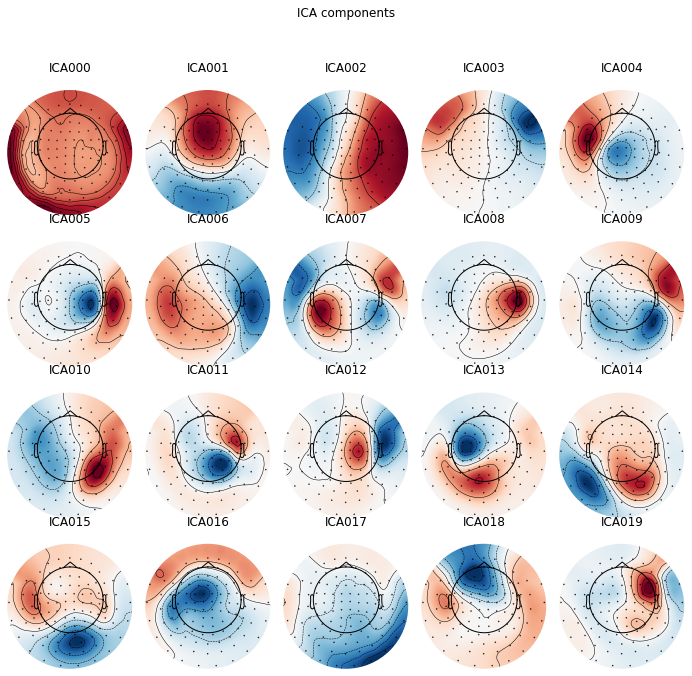

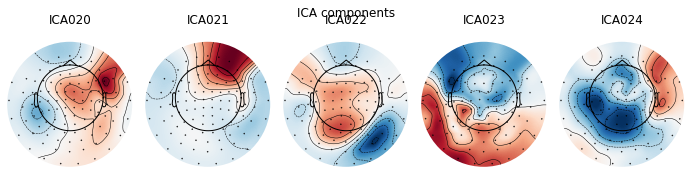

[<Figure size 702x678.24 with 20 Axes>, <Figure size 702x169.56 with 5 Axes>]

In [13]:
# Your code here
ica.plot_components()

MemoryError: Unable to allocate 158. MiB for an array with shape (138, 376, 400) and data type float64

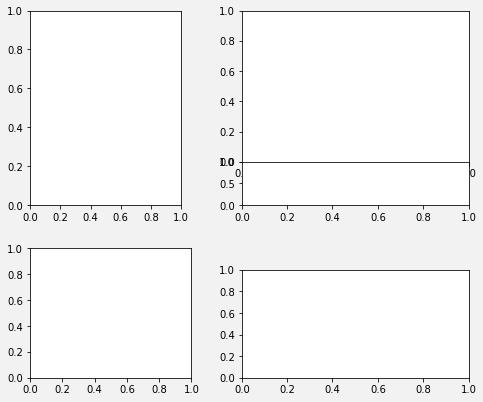

In [17]:
# Your code here
ica.plot_properties(raw, picks=1)

Which ones do you think are artifacts, such as blinks, eye movements, or heartbeats?

In this example we are going to remove component 0 to 3 as they represent movement, heartbeat, saccades, and blink artifacts, respectively.